# ========================
# ETF Analysis with PySpark
# ========================

# 1. Define Business Problem & Objectives
"""
Business Problem: Optimize ETF trading strategies using technical indicators to improve investment returns.
Objectives:
- Generate moving average crossover signals for trading decisions
- Evaluate signal effectiveness through backtesting
- Forecast future prices to inform long-term investment strategies
"""

# 2. Data Collection & Preprocessing

In [3]:
from datetime import date, timedelta  # <-- FIX HERE
import numpy as np
import pandas as pd
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# Fetch 5 years of VTI data

In [4]:
ticker = "VTI"
end_date = date.today()
start_date = end_date - timedelta(days=5*365)
df = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Save raw data

In [5]:
df.to_csv(f'{ticker}_stock_data.csv', index=True)

# Initialize Spark

In [6]:
spark = SparkSession.builder.appName("ETF_Analysis").getOrCreate()
sdf = spark.createDataFrame(df.reset_index())

# Clean column names

In [7]:
for col_name in sdf.columns:
    new_col_name = col_name.replace("(", "").replace(")", "").replace("'", "").replace(",", "").replace("VTI", "").strip()
    sdf = sdf.withColumnRenamed(col_name, new_col_name)

# 3. Moving Averages & Signal Generation
# Calculate moving averages

In [8]:
window_10 = Window.orderBy("Date").rowsBetween(-9, 0)
window_100 = Window.orderBy("Date").rowsBetween(-99, 0)

sdf = (sdf
       .withColumn("10_day_MA", avg("Close").over(window_10))
       .withColumn("100_day_MA", avg("Close").over(window_100)))

sdf = sdf.withColumn("Signal",
    when(col("10_day_MA") > col("100_day_MA"), lit(1))
    .when(col("10_day_MA") < col("100_day_MA"), lit(-1))
    .otherwise(lit(0))
)

# 4. Signal Analysis
# Count signals

In [9]:
signal_counts = sdf.groupBy("Signal").count()
print("Signal Distribution:")
signal_counts.show()


Signal Distribution:
+------+-----+
|Signal|count|
+------+-----+
|     0|   10|
|    -1|  271|
|     1|  975|
+------+-----+



# Calculate hypothetical returns

In [10]:
returns = sdf.select(
    "Date",
    "Close",
    "Signal",
    (col("Close").cast("float") - lag("Close", 1).over(Window.orderBy("Date"))).alias("PriceChange")
).na.drop()

profit_analysis = returns.groupBy("Signal").agg(
    sum(when(col("Signal") == 1, col("PriceChange")).otherwise(0)).alias("Buy_Profit"),
    sum(when(col("Signal") == -1, -col("PriceChange")).otherwise(0)).alias("Sell_Profit")
)

print("\nProfit Analysis:")
profit_analysis.show()


Profit Analysis:
+------+------------------+------------------+
|Signal|        Buy_Profit|       Sell_Profit|
+------+------------------+------------------+
|     0|               0.0|               0.0|
|    -1|               0.0|-25.94842529296875|
|     1|155.36888122558594|               0.0|
+------+------------------+------------------+



# 5. Visualization

In [11]:
import matplotlib.pyplot as plt

# Convert to Pandas for visualization

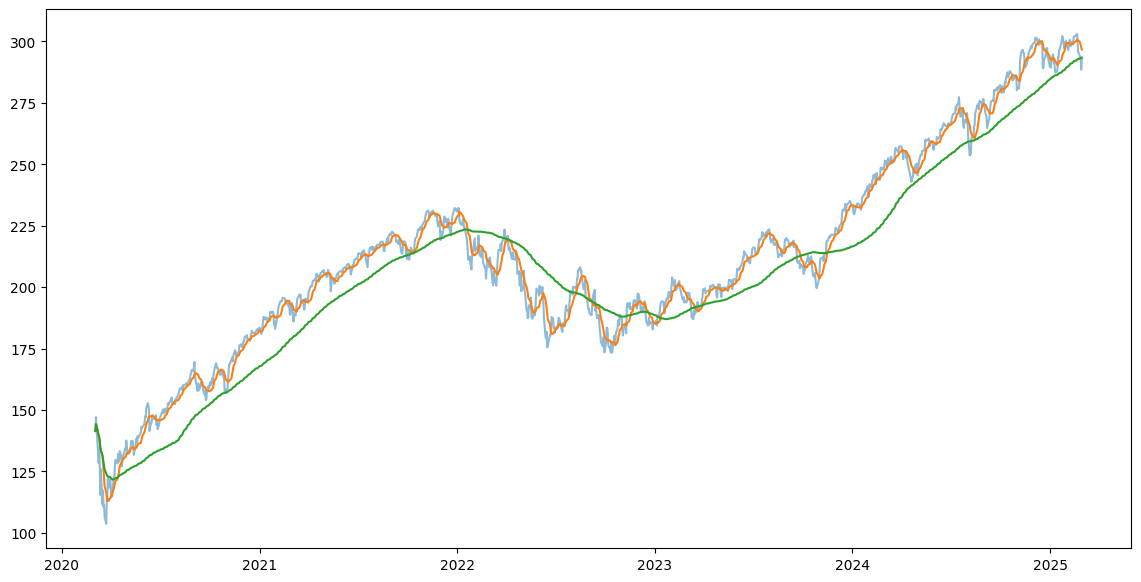

In [12]:
pdf = sdf.orderBy("Date").toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])

plt.figure(figsize=(14, 7))
plt.plot(pdf['Date'], pdf['Close'], label='Close Price', alpha=0.5)
plt.plot(pdf['Date'], pdf['10_day_MA'], label='10-day MA')
plt.plot(pdf['Date'], pdf['100_day_MA'], label='100-day MA')

# Add signal markers

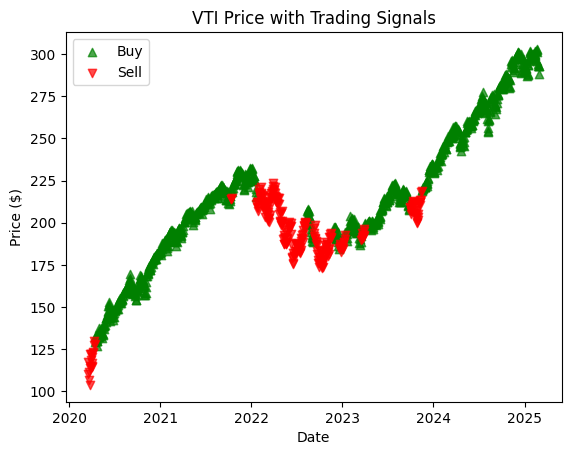

In [13]:
plt.scatter(pdf[pdf['Signal'] == 1]['Date'],
            pdf[pdf['Signal'] == 1]['Close'],
            marker='^', color='g', label='Buy', alpha=0.7)
plt.scatter(pdf[pdf['Signal'] == -1]['Date'],
            pdf[pdf['Signal'] == -1]['Close'],
            marker='v', color='r', label='Sell', alpha=0.7)
plt.title(f'{ticker} Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.savefig('trading_signals.png')
plt.show()

# ==============================
# Forecasting with Prophet
# ==============================

# 1. Data Preparation

In [14]:
from prophet import Prophet
from prophet.serialize import model_to_json

# Prepare data for Prophet

In [15]:
prophet_df = sdf.select(
    col("Date").alias("ds"),
    col("Close").alias("y")
).toPandas()

# Split into train/holdout (last 90 days)

In [16]:
train = prophet_df[:-90]
holdout = prophet_df[-90:]

# 2. Model Training

In [17]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbz60y6v/k8_u0fdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbz60y6v/5pshd9xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80170', 'data', 'file=/tmp/tmpqbz60y6v/k8_u0fdo.json', 'init=/tmp/tmpqbz60y6v/5pshd9xd.json', 'output', 'file=/tmp/tmpqbz60y6v/prophet_modelfxa92uyu/prophet_model-20250302062232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Save model

In [18]:
with open('prophet_model.json', 'w') as f:
    f.write(model_to_json(model))

# 3. Forecasting

In [19]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# 4. Evaluation (Corrected)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge forecast with actuals and clean data

In [21]:
eval_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]\
                .join(holdout.set_index('ds'), how='inner')  # Use inner join to align dates

# Drop any remaining NaN values just in case

In [22]:
eval_df = eval_df.dropna()

# Calculate metrics only if we have comparable data

In [23]:
if not eval_df.empty:
    mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
    rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))

    print(f"\nModel Performance ({len(eval_df)} comparable days):")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
else:
    print("Warning: No overlapping dates between forecast and holdout for evaluation")


Model Performance (60 comparable days):
MAE: 6.12
RMSE: 7.22


# 5. Visualization

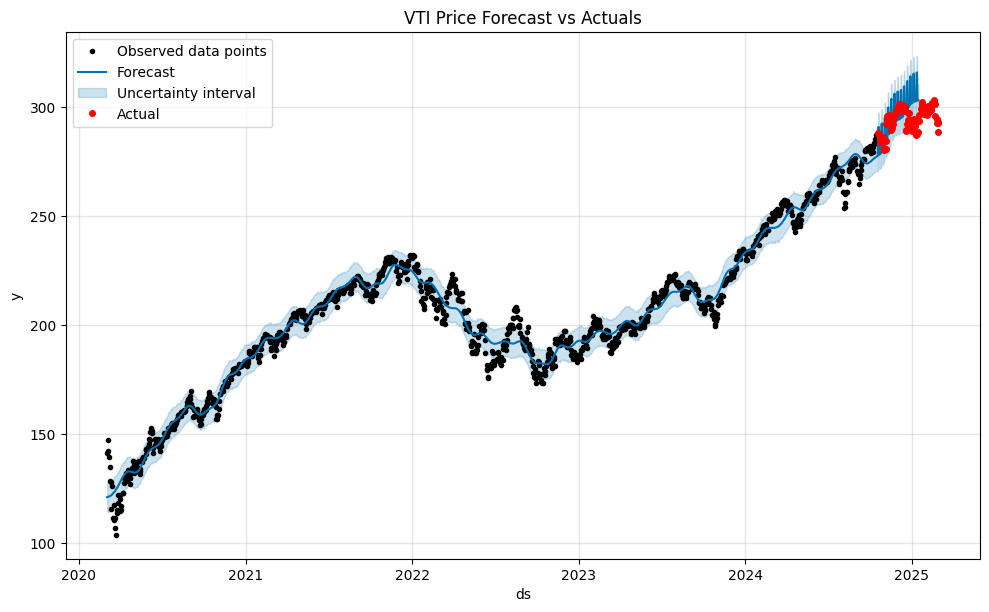

In [24]:
fig = model.plot(forecast)
ax = fig.gca()
ax.plot(holdout['ds'], holdout['y'], 'ro', markersize=4, label='Actual')
ax.legend()
plt.title(f'{ticker} Price Forecast vs Actuals')
plt.savefig('prophet_forecast.png')
plt.show()

# Uncertainty intervals

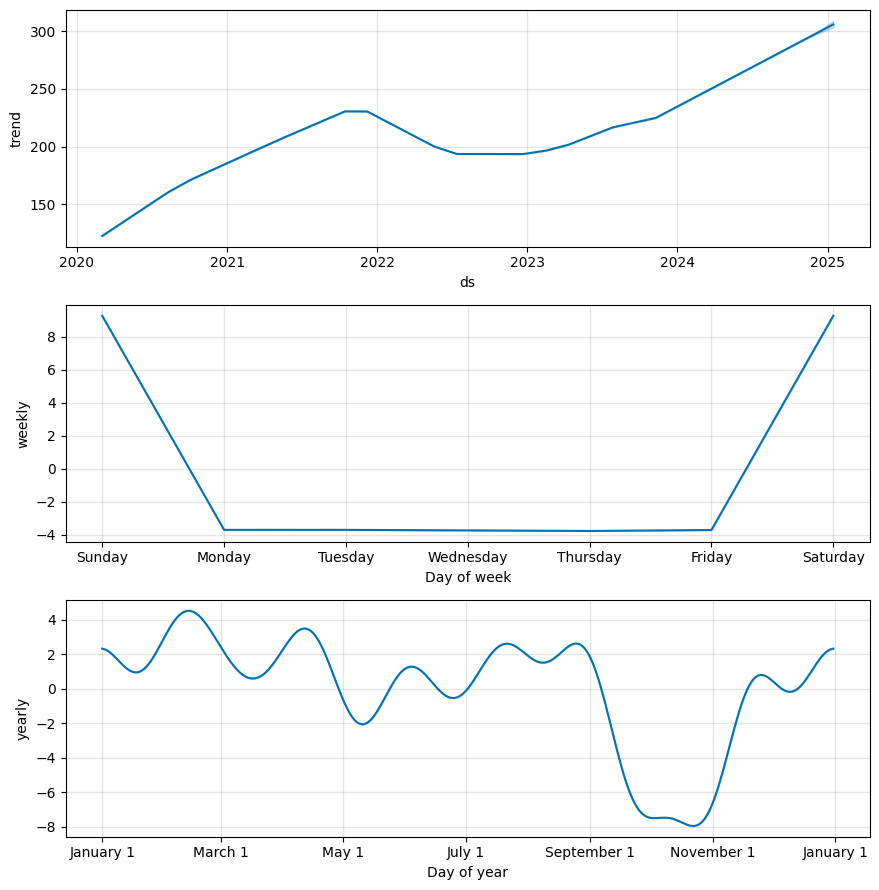

In [25]:
fig2 = model.plot_components(forecast)
plt.show()